In this project I created a citation network for all the papers in this [Citation-Network V1](https://www.aminer.org/citation)
and used the PageRank algorithm to rank each paper in the network by importance. I judged each paper’s importance by the number of other articles in the network that reference to it, either directly or indirectly.

The dataset I chose to analyze contains research citation data for 629,814 papers and 632.752 citations. Each paper was labeled with its abstract, authors, year, venue, title, and references. I wanted to generate the most important papers in this dataset according to how often it was referenced by other papers. So I built a network in which every node was a single paper and every edge was a reference to another paper.

In extracted data from the outputacm.txt file, containing all the citation information, and created a network graph with paper indices as nodes and tuples of paper indices as edges.
I then analyzed weakly connected components on the entire network G. Because I realized most of G is sparsely connected or simply individual nodes, I decided to use Networkx’s built-in function for finding connected graphs (called components). The function found all the connected graphs within G and output information for some sample components.

Next, I analyzed one of these components--the connected graph G2 that begins at node 24. This choice was made due to limitations in time and computational power. I created the graph of all nodes connected to 24 and ran two types of analysis on G2: betweenness and PageRank. Betweenness uses betweenness centrality to find nodes that likely connect two different clusters (​referred to here as a broker​). I outputted these top nodes as text. PageRank uses a type of eigenvector centrality to find the most important nodes in a network. I used PageRank in the visualization function to label these important nodes and display the network, exported as an image.

In [34]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter

In [35]:
#clean the data in the text file and store the useful values, return a graph
def cleanData(f):
    nodes = list()
    edges = list()

    data = open(f, 'r').read()
    blocks = re.split(r'\n\n', data)
    for paper in blocks:
        try:
            name = re.search(r'#\*(.*)', paper).group(1)
            index = int(re.search(r'#index(.*)', paper).group(1))
            ref = re.findall(r'#%(.*)', paper)
            nodes.append(index)
            if len(ref) != 0:
                for i in ref:
                    i = int(i)
                    edges.append((index, i))
        except:
            next
            
    G = nx.DiGraph(name = "Citation Network")
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    print ("Finished cleaning data and generating graph")
    return G


In [36]:
#find page rank for a special graph
#return a dictionary with node index as keys and importance(page rank) as values
def createPageRank(G): 
    pr = nx.pagerank(G, alpha = 0.85)
    print ("Finished generating page rank")
    #print pr
    return pr

In [37]:
#either return a list, with k most important nodes
def findImportantPages(pr, k):
    newPR = sorted(pr, key=pr.get, reverse=True)[:k]
    return newPR

In [38]:
#find all nodes connected to the start node
#return the a directed graph of connected nodes 
def connected(G, start):
    G2 = nx.DiGraph(name="Connected Graph Starting from Paper"+str(start))           #the new graph of the smaller network
    G2.add_node(start)
    
    visited = dict()
    for n in G:
        visited[n] = False

    potential_nodes = list()
    potential_nodes.append(start)
    while len(potential_nodes) != 0:
        node = potential_nodes.pop(0)
        if visited[node] == True:
            break
        else:
            for n in G.successors(node):    #n is the neighbor node that our node points to 
                G2.add_node(n)
                G2.add_edge(node, n)
                potential_nodes.append(n)
            for n in G.predecessors(node):
                G2.add_node(n)
                G2.add_edge(n, node)
                potential_nodes.append(n)
        visited[node] = True
    #print "Finished finding connected graph"
    return G2

In [39]:
#visualize the image
#the k most important nodes are colored and labeled
#node sizes are proportion to their page rank 
def visualize(G, k, color): 
    #generate pagerank and find the k most important node according to page rank
    print ("=====================================================")
    print ("Running visualization using PageRank...")
    pr = nx.pagerank(G, alpha = 0.85)
    important_nodes = findImportantPages(pr, k)
    
    #add color and label to the most important nodes
    #adjust the size of the nodes according to page rank
    color_map = list()
    label = dict()
    size = list()
    multiple = 600
    for n in G.nodes:
        if n in important_nodes:
            color_map.append(color)
            label[n] = n
            #print n

        else:
            color_map.append('blue')
        size.append(pr[n]*multiple)
    
    nx.draw_spring(G, with_labels = True, labels = label, font_size = 8, 
                         node_size = size,  node_color = color_map,
                         arrowsize = 6, width = 0.1)
    
    plt.savefig("demo_spring.png", dpi = 150)
    plt.show()

In [51]:
#calculate betweenness centrality and return top nodes
#predicts which nodes will connect separate clusters
def betweenness(G,color):
    print ("=================================================")
    print ("Running betweenness analysis...")
   
    
    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
        
    
    betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
    # Assign each to an attribute in your network
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    
    

    print("Top nodes most like to act like a broker (connect disparate clusters): ")
    for b in sorted_betweenness[:20]:
        if b[1] >0:
            print ("Paper Index #", b[0], "which has degree ", G.nodes[b[0]]['degree'])
            
#    nx.set_node_attributes(G, betweenness_dict, 'betweenness')
#    
#    color_map = list()
#    label = dict()
#    
#    for n in G.nodes:
#        if n in sorted_betweenness[:20]:
#            color_map.append(color)
#            label[n] = n
#            #print n
#        else:
#            color_map.append('blue')
#            
    #nx.draw(G,with_labels = True, node_color = color_map)

#    nx.draw_spring(G, with_labels = True, labels = label, font_size = 8, 
#                         node_color = color_map,
#                         arrowsize = 6, width = 0.1)
    
    #plt.savefig("brokerage_test", dpi = 150)

In [48]:
def more_components(subgraphs): #use this to play around more with component graphs
 #      if you have the computational resources, find the largest subgraph 
 #   giant = max((subgraphs), key=len)
 #   print nx.info(giant)
    i=0
    start = 0
    #start = 201000
    #200374 has 5 nodes.
    #20116 is also interesting. 
    #201345
    #201639
    
    num_to_analyze = 10
    for subgraph in subgraphs:
        if i > start and i < start + num_to_analyze:
            num_nodes = nx.number_of_nodes(subgraph)
            #print "========================================================"
            print ("Subgraph #", i)
            if num_nodes == 1:
                print ("One node only")
            elif num_nodes >1 and num_nodes <= 800:
                
                print (nx.info(subgraph), "Between 1 and 800 nodes")
                brokerage(subgraph,'red')
                nx.draw(subgraph.copy(), with_labels=True)
                plt.show()
                #visualize(subgraph,10,'red')
            else: 
                
                print (nx.info(subgraph))#, "Too many nodes to analyze for now"
        elif i >= start + num_to_analyze:
            break
        i+=1

In [49]:
#much of the entire citation network isn't connected with each other.
#use this function to find connected component graphs within G.
        
def component_graphs(G):
    print ("==========================================================")
    print ("COMPONENT ANALYSIS")
    subgraphs = (G.subgraph(c) for c in nx.weakly_connected_components(G))
    num_subgraphs = nx.number_weakly_connected_components(G)
    
    print ("Number of weakly connected components: ", num_subgraphs)
    print ("Some sample components are: ")

    
    i=0
    for subgraph in subgraphs:
        if i == 3 or i==5 or i==10000 or i==200374 or i==201345:
            num_nodes = nx.number_of_nodes(subgraph)
            print ("Component #", i)
            if num_nodes ==1:
                print ("One node only")
            else:
                print (nx.info(subgraph))
            print ("\n")
        i+=1    
        

Finished cleaning data and generating graph
Name: Citation Network
Type: DiGraph
Number of nodes: 629814
Number of edges: 632749
Average in degree:   1.0047
Average out degree:   1.0047
COMPONENT ANALYSIS
Number of weakly connected components:  416925
Some sample components are: 
Component # 3
One node only


Component # 5
Name: Citation Network
Type: DiGraph
Number of nodes: 205951
Number of edges: 625447
Average in degree:   3.0369
Average out degree:   3.0369


Component # 10000
One node only


Component # 200374
Name: Citation Network
Type: DiGraph
Number of nodes: 3
Number of edges: 2
Average in degree:   0.6667
Average out degree:   0.6667


Component # 201345
One node only


Running betweenness analysis...
Top nodes most like to act like a broker (connect disparate clusters): 
Paper Index # 436906 which has degree  12
Running visualization using PageRank...


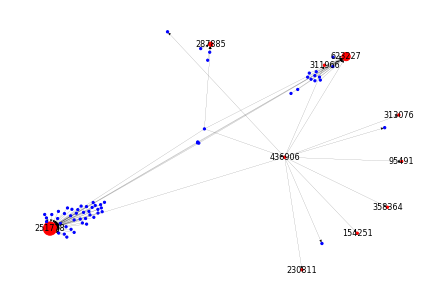

In [52]:
G = cleanData('outputacm.txt')
print ("==========================================================")
print (nx.info(G))
component_graphs(G)
    
#use one component graph called G2
G2 = connected(G, 24)
betweenness(G2,'red')
visualize(G2, 10, 'red')

Results:  

The average node in the entire citation network is only referenced by one paper and only references one other paper.  
The entire citation network is made up of 629,814 nodes, yet it contains 416,925 separate graphs! This means that many of the nodes do not connect to one another at all. On the other hand, occasional components can contain many nodes, such as component #5, which as 205,951 nodes.  

Due to limits in computational power, I limited the analysis to a single component, starting from Paper 24. We call this Graph G2.  
Next is betweenness centrality. These top nodes likely connect clusters of nodes.

I would also like to rank the most important nodes in this graph according to the PageRank algorithm.
Rank papers by importance as measured through the PageRank algorithm based on the number of outside papers that reference them:
1. Introduction to algorithms by Thomas T. Cormen,Charles E. Leiserson,Ronald L. Rivest (index 45338)
2. Simulation Modeling and Analysis, 2nd edition by Averill M. Law,W. David Kelton (index 24651)
 
3. The nature of statistical learning theory by Vladimir N. Vapnik (index 586607)
4. The art of computer programming, volume 2 (3rd ed.): seminumerical algorithms by
Donald E. Knuth (index 81323)
5. The art of computer programming, volume 1 (3rd ed.): fundamental algorithms by
Donald E. Knuth (index 79620)
6. C4.5: programs for machine learning by J. Ross Quinlan (index 214951)
7. A relational model of data for large shared data banks by E. F. Codd (index 326368)
8. Compilers: principles, techniques, and tools by Alfred V. Aho,Ravi Sethi,Jeffrey D.
Ullman (index 162585)
9. Pattern Classification (2nd Edition) by Richard O. Duda,Peter E. Hart,David G. Stork
(index 311413)
10. Adaptation in natural and artificial systems by John H. Holland (index 517247)  

It seems that the component I have captured is likely papers from one scientific field; in this case, it appears to be computer programming and related algorithms. These papers cross-reference one another in this graph. We could expect this component to be entirely disconnected from fields such as ecology.


Graph G2 below:

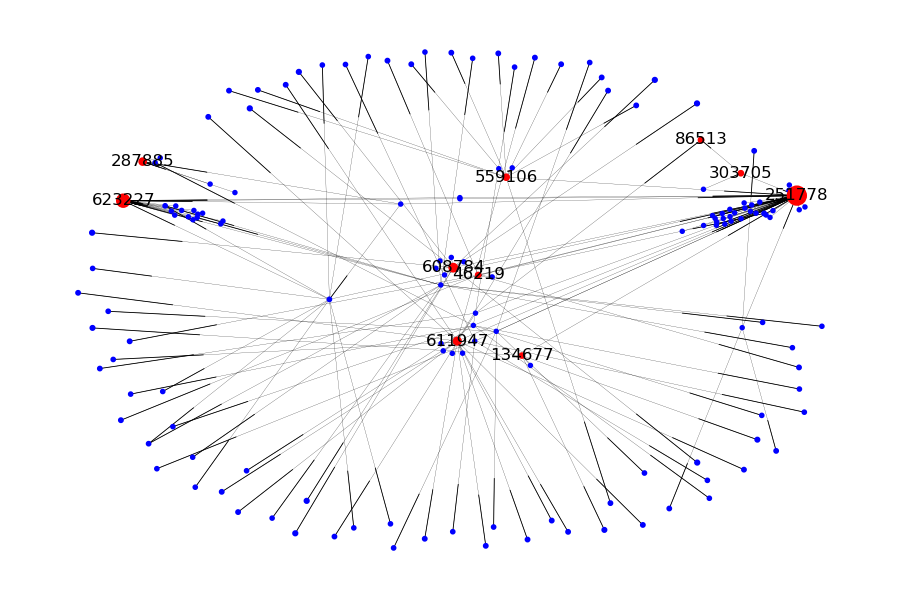

In [45]:
from IPython.display import Image
Image("demo_spring.png")

Within the graph G2, I ran PageRank on the 150+ nodes to label the top 10 nodes in red and produce this network. Paper 251778 is highly connected with other papers as shown by its node size and the edges coming from it. We can see that it both references and is referenced by many other papers. Paper 623227 would be the next most important paper as seen by its node size and connectivity.
The top 10 papers, in red, for Graph G2 are:
* 559106
* 608784
* 134677
* 303705
* 611947
* 623227
* 46219
* 287885
* 251778
* 86513  

Upon examining the papers, we can observe that they are close in subject as expected in a scientific field.